In [1]:
from random import *
from math import *
from copy import *
from IPython.display import Image
import cairocffi as cairo

## Job class
Initial parameters: <br>
- name : unique id of the job<br>
- sub_time: submission time<br>
- alpha : speed up factor (can be thought of as the communication time), should be somewhere between 0.5 and 1
- data: data to be processed, required for the reconfiguration time (see equation below)
- mass: mass of computation : area if run with one server 
- min_num_servers : minimum number of servers required for the job to be run
- max_num_servers : maximum number of servers the job should be run on
<br>

Parameters updated as job is scheduled: 
- tasks: array of task object, initially empty


### Jobs and tasks
A job is broken into smaller tasks that can be processed on a different amount of servers. The number of servers used will impact the processing time according to the equation shown below.


### Processing time of a task
$time = \frac{mass}{(num\_servers)^{alpha}}$<br>
or<br>
$mass= time \times (num\_servers)^{alpha}$


### Reconfiguration time
Time required to reconfigure the data if the number of servers is either increased or decreased. <br>
if $n\geq m$:<br>
$T_{n\rightarrow m} = \frac{D}{n}(\lceil \frac{n}{m}\rceil - 1)$<br>
if $n\leq m$:<br>
$T_{n\rightarrow m} = \frac{D}{m}(\lceil \frac{m}{n}\rceil - 1)$<br>

where $D$ is the data amount in the application, $n$ number of servers in the previous process and $m$ the number of servers in the new process

In [2]:
class Job():
    def __init__(self, name, sub_time, alpha, data, mass, min_num_servers, max_num_servers):
        self.name = name
        self.sub_time = sub_time
        self.alpha = alpha
        self.data = data
        self.mass = mass
        self.min_num_servers = min_num_servers
        self.max_num_servers = max_num_servers
        
    



## Task class
Initial parameters: <br>
- job_name: The job to which the task belongs
- start_time
- end_time
- mass_executed
- servers : list of servers the task is executed on

In [3]:
class Task(object):
    def __init__(self, job_name, mass_executed, servers, start_time, end_time):
        self.job_name = job_name
        self.mass_executed = mass_executed
        self.servers = servers
        self.start_time = start_time
        self.end_time = end_time

class Reconfig(Task):
    def __init__(self, job_name, servers, start_time, end_time):
        Task.__init__(self, job_name, mass_executed, servers, start_time, end_time)
        self.mass_executed = 0

## Server

A server is a computation unit 

In [4]:
class Server(object):
    def __init__(self, name):
        self.name = name

Instantiating the different jobs to be processed and servers

In [5]:
job1 = Job('job1', sub_time = 0, alpha = 1, data = 1000, mass = 10, min_num_servers = 2, max_num_servers=3)
job2 = Job('job2', sub_time = 1, alpha = 1, data = 500, mass = 20, min_num_servers = 1, max_num_servers=3)


In [6]:
jobs = [job1, job2]

In [7]:
#Sort jobs by submission time
jobs = sorted(jobs, key=lambda k: k.sub_time) 


In [8]:
servers = [Server('server'+str(i)) for i in range(5)]

In [9]:
len(servers)

5

## Scheduler - state of whole thing
Manager should be able to access objects and query.

In [155]:
class Schelduler(object):
    def __init__(self, servers):        
        self.servers = servers
        self.jobs = []
        self.tasks = []
        
    def schedule(self,job):
        self.jobs.append(job)
        #schedule the first task
        if len(self.tasks) == 0:
            #check the number of servers used to schedule the task
            num_servers = job.max_num_servers if job.max_num_servers < len(self.servers) else len(self.servers)
            #chooses servers from the list
            servs = sample(self.servers, k = num_servers)
            #find the execution time
            exec_time = self._exec_time(job.mass, job.alpha, num_servers)
            start_time = job.sub_time
            end_time = job.sub_time + exec_time
            mass_executed = job.mass
            #add task to the list of tasks
            self.tasks.append(Task(job.name, mass_executed, servs, start_time, end_time))
        
        return self.tasks
    
    def _exec_time(self, mass, alpha, num_serv):
        return mass / (num_serv)**alpha
    
    def _available_servers(self, time):
        #Start with all servers as potential servers
        candidate_servers = [s for s in servers]
        #if no task has been schedule yet then all servers are valid candidates
        if len(self.tasks) == 0:
            return candidate_servers
        #remove servers that are busy at the given time
        for t in self.tasks:
            for s in t.servers:
                if self._is_server_in_list(s, candidate_servers):
                    if time < t.end_time and time > t.start_time:
                        candidate_servers.remove(s)          
        return candidate_servers
    
    def _is_server_in_list(self, s1, ss):
        for s in ss:
            if self._compare_servers(s1,s):
                return True
        return False
    
    def _compare_servers(self, server1, server2):
        if server1.name == server2.name:
            return True
        else:
            return False
    
    def num_reconfig(self):
        return 0
    
    def is_job_completed(self, job):
        return False
    
    def jobs_reconfigured(self, jobs):
        return [] #array of jobs
    
    #Calculates the reconfiguration time 
    def reconfig_time(self, data, init_servers, final_servers):
        if init_servers > final_servers:
            return data / init_servers * (ceil(init_servers / final_servers)-1)
        return data / final_servers * (ceil(final_servers / init_servers)-1)
    
    def num_jobs(self):
        return len(jobs)
    
    def make_span(self):
        min_time = min([t.start_time for t in tasks])
        max_time = max([t.end_time for t in tasks])
        return max_time - min_time
    
    def number_of_servers(self):
        return len(servers)
    
    def job_names(self):
        return [j.name for j in self.jobs]
    
    def server_names(self):
        return [s.name for s in self.servers]
    
    def print_tasks(self):
        for t in self.tasks:
            print ('Job name: {}; mass_exec: {}; servers: {}; start_time: {}; end_time: {}'.format(t.job_name, t.mass_executed,
                                                                                        len(t.servers),t.start_time,t.end_time))

In [156]:
scheduler = Schelduler(servers)

In [157]:
tasks = scheduler.schedule(jobs[0])


In [158]:
scheduler.print_tasks()

Job name: job1; mass_exec: 10; servers: 3; start_time: 0; end_time: 3.3333333333333335


## Visualisation tools

In [169]:
class viz_tools():
    def draw_gannt(self, scheduler, filename, isDrawGrid = False):
        WIDTH, HEIGHT = 800, 800
        surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
        ctx = cairo.Context(surface)

        ctx.scale(WIDTH, HEIGHT)  # Normalizing the canvas

        ctx.rectangle(0, 0, 1, 1)  # Rectangle(x0, y0, width, height)
        ctx.set_source_rgb(1, 1, 1)
        ctx.fill()
            
        #Assign a random color each job
        jobs_colors = {j_name : [random() for j in range(3)] for j_name in  scheduler.job_names()}
        
        max_time = 1.01*scheduler.make_span()
        num_servs = scheduler.number_of_servers()
        x_offset = 0.1
        y_offset = 0.1
        width_scaling = (1 - x_offset * 2) / max_time
        height_scaling = (1 - y_offset * 2) / num_servs
        
        #Position each for each server
        servers_pos = {scheduler.server_names()[i] : y_offset + i*height_scaling 
                       for i in range (scheduler.number_of_servers())}
        
        for t in scheduler.tasks:
            j_name = t.job_name
            t_time = t.end_time - t.start_time
            for s in t.servers:
                 # Rectangle(x0, y0, width, height)
                ctx.rectangle(x_offset + t.start_time * width_scaling, servers_pos[s.name],
                               width_scaling * t_time,  height_scaling)

                ctx.set_source_rgb(jobs_colors[j_name][0], jobs_colors[j_name][1], jobs_colors[j_name][2])
                ctx.fill()            

        if (isDrawGrid):
            for i in range(ceil(scheduler.make_span()) + 1):

                    ctx.move_to(x_offset + i * width_scaling, y_offset)
                    ctx.line_to(x_offset + i * width_scaling, 1 - y_offset)
                    ctx.set_source_rgba(0, 0, 0, 0.9)  
                    ctx.set_line_width(0.001)
                    ctx.stroke()

            for j in range(num_servs + 1):
                ctx.move_to(x_offset , y_offset + j * height_scaling)
                ctx.line_to(x_offset + max_time, y_offset + j * height_scaling)
                ctx.set_source_rgba(0, 0, 0, 0.9)  
                ctx.set_line_width(0.001)
                ctx.stroke()
        
        #Label axis
        ctx.set_source_rgb(0, 0, 0)
        ctx.set_font_size(0.05)
        ctx.move_to(0.8,0.97)
        ctx.show_text("Time")
        ctx.move_to(0,0.07)
        ctx.show_text("Servers")
        
        surface.write_to_png(filename)  # Output to PNG

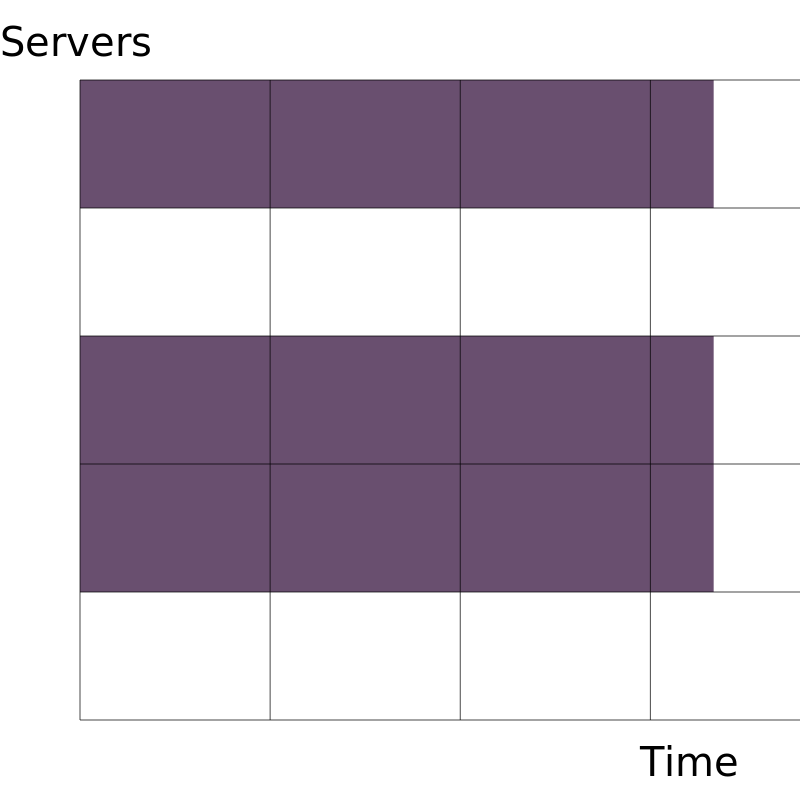

In [170]:
vz_tools = viz_tools()
file_name = 'test.png'
vz_tools.draw_gannt(scheduler, file_name, True)
Image(filename = file_name, width=400, height=400)